# Titanic: Machine Learning from Disaster

author: olala7846@gmail.com
for more detail about the dataset, please reference [Kaggle](https://www.kaggle.com/c/titanic/data)

## First, we have to observe that dataset.
Get to know how many rows training and testing data we have, and which fields may have missing values. 

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sklearn
import math

%matplotlib inline

TRAIN_FILE = './train.csv'
TEST_FILE = './test.csv'
train_orig = pd.read_csv(TRAIN_FILE)
test_orig = pd.read_csv(TEST_FILE)
# Sample some training data
train_orig.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [70]:
# describe training dataset.
train_orig.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [71]:
# describe testing dataset.
test_orig.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


So we can see both training and testing data has some rows are missing the `Age` column, and one of the testing data is missing the `Fare` column.

## Play around the data
Get a sense of what features may or maynot effects the results.

In [82]:
print('See how Pclass effects survival rates:')
train_orig[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()


See how Pclass effects survival rates:


,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [83]:
print('See how Sex effects survival rates:')
train_orig[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

See how Sex effects survival rates:


,Sex,Survived
0,female,0.742038
1,male,0.188908


See how Embarked distribute


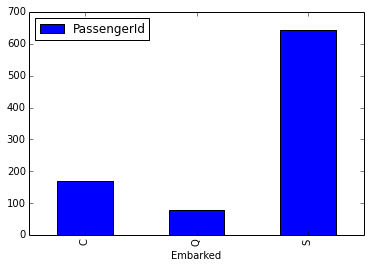

In [88]:
print('See how Embarked distribute')
train_orig[['Embarked', 'PassengerId']].groupby('Embarked').count().plot(kind='bar')

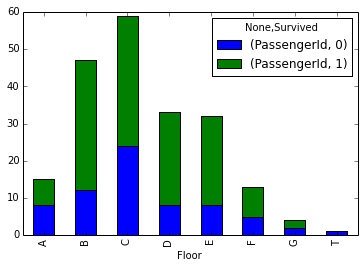

In [99]:
train_orig['Floor'] = train_orig['Cabin'].apply(lambda x: x[0] if isinstance(x, str) else x)
(train_orig[['Floor', 'PassengerId', 'Survived']]
 .groupby(['Floor', 'Survived'])
 .count()
 .unstack()
 .plot(kind='bar', stacked=True))


In [101]:
train_orig[['Floor', 'Survived']].groupby('Floor').5()

,Survived
Floor,
A,0.466667
B,0.744681
C,0.593220
D,0.757576
E,0.750000
F,0.615385
G,0.500000
T,0.000000


See how fare effects survival rates:


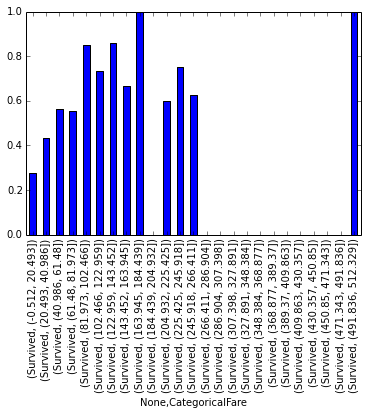

In [105]:
print('See how fare effects survival rates:')

train_orig['CategoricalFare'] = pd.cut(train_orig.Fare, 25)

(train_orig[['CategoricalFare', 'Survived']]
 .groupby(['CategoricalFare'])
 .mean()
 .unstack()
 .plot(kind='bar', stacked=True))


See how Pclass effects survival rates:
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
See how Sex effects survival rates:
      Sex  Survived
0  female  0.742038
1    male  0.188908
See how Age effects survival rates:


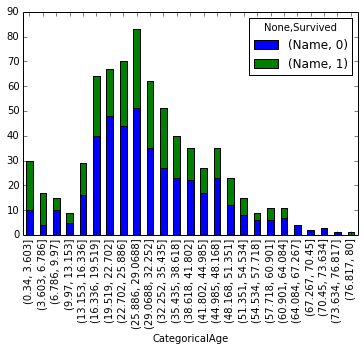

In [80]:
print('See how Age effects survival rates:')

train_orig['CategoricalAge'] = pd.cut(train_orig.Age, 25)                                    

(train_orig[['CategoricalAge', 'Survived', 'Name']]
 .groupby(['CategoricalAge', 'Survived'])
 .count()
 .unstack()
 .plot(kind='bar', stacked=True))


In [ ]:
# Just that it's easire while developing on ipynb
train = train_orig.copy()
test = test_orig.copy()
full_data = [train, test]

## Feature Engineering

In [79]:
# some commonly used data engineering
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    # not alone unless familysize == 1
    dataset['IsAlone'] = 0 
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
    
    

## Data Cleaning

In [76]:
## Clean data and turn strings into vector

full_data = [train, test]
for dataset in full_data:
    # Convert Sex from string to vector
    dataset['Sex'] = dataset['Sex'].map({'male': 1, 'female': 0}).astype(int)
    
    # Randomly assign age for age == NaN
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_cnt = dataset['Age'].isnull().sum()
    age_null_rand_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_cnt)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_rand_list
    dataset['Age'].astype(int)
    
    # Assign average Fare to fare == NaN
    fare_avg = dataset.Fare.mean()
    dataset.Fare[np.isnan(dataset.Age)] = fare_avg
    

/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [74]:
# observe data
# process data
# TODO(Olala): train test split
# TODO(Olala): train classifier
# eval data on test set.

In [75]:
import math
math.floor(13.5) % 5


3.0